In [44]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import utils
import dataloaders
import torchvision
from trainer import Trainer

torch.random.manual_seed(0)
np.random.seed(0)


### Dataset and hyperparameters

In [45]:
# Hyperparameters
learning_rate = 0.0192
num_epochs = 5
batch_size = 64

# Use CrossEntropyLoss for multi-class classification
loss_function = torch.nn.CrossEntropyLoss()


def create_model():
    """Initializes the model"""
    model = nn.Sequential(
        nn.Flatten(),  # Flattens the image from shape (batch_size, C, Height, width) to (batch_size, C*height*width)
        nn.Linear(28 * 28 * 1, 10),
    )
    model = utils.to_cuda(model)
    return model


image_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
    ]
)

dataloader_train, dataloader_test = dataloaders.load_dataset(
    batch_size, image_transform
)
example_images, _ = next(iter(dataloader_train))
print(
    f"The tensor containing the images has shape: {example_images.shape} (batch size, number of color channels, height, width)",
    f"The maximum value in the image is {example_images.max()}, minimum: {example_images.min()}",
    sep="\n\t",
)
example_images = utils.to_cuda(example_images)


The tensor containing the images has shape: torch.Size([64, 1, 28, 28]) (batch size, number of color channels, height, width)
	The maximum value in the image is 1.0, minimum: 0.0


# Task 4a)

In [46]:
# Create the model
model = create_model()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
output = model(example_images)
print("Output shape:", output.shape)
expected_shape = (batch_size, 10)  # 10 since mnist has 10 different classes
assert (
    output.shape == expected_shape
), f"Expected shape: {expected_shape}, but got: {output.shape}"


Output shape: torch.Size([64, 10])


### Train model without normalization

In [47]:
trainer = Trainer(
    model=model,
    dataloader_train=dataloader_train,
    dataloader_test=dataloader_test,
    batch_size=batch_size,
    loss_function=loss_function,
    optimizer=optimizer,
)
task_a_train_loss_dict, task_a_test_loss_dict = trainer.train(num_epochs)


Training epoch 4: 100%|██████████| 938/938 [00:04<00:00, 230.15it/s]


### Train model with normalization

In [48]:
# Normalization-transform
image_transform_normalized = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(0.5, 0.5),
    ]
)

# Reload dataset with normalization
dataloader_train, dataloader_test = dataloaders.load_dataset(
    batch_size, image_transform_normalized
)
example_images, _ = next(iter(dataloader_train))
example_images = utils.to_cuda(example_images)

# Create model again
model = create_model()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Train again with normalization
trainer = Trainer(
    model=model,
    dataloader_train=dataloader_train,
    dataloader_test=dataloader_test,
    batch_size=batch_size,
    loss_function=loss_function,
    optimizer=optimizer,
)
task_a_normalized_train_loss_dict, task_a_normalized_test_loss_dict = trainer.train(
    num_epochs
)
normalized_loss, normalized_accuracy = utils.compute_loss_and_accuracy(dataloader_test, model, loss_function)


Training epoch 4: 100%|██████████| 938/938 [00:07<00:00, 130.03it/s]


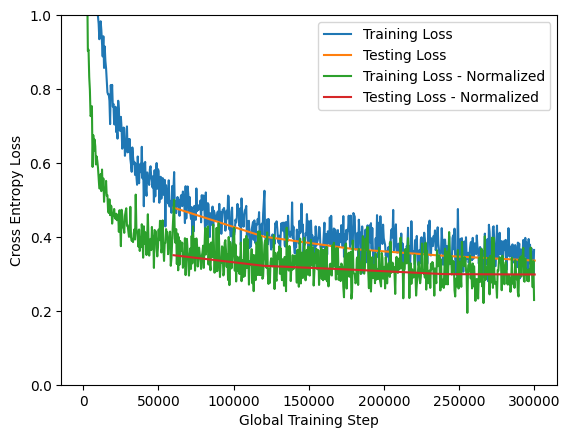

In [49]:
# We can now plot the training loss with our utility script
utils.plot_loss(task_a_train_loss_dict, label="Training Loss")
utils.plot_loss(task_a_test_loss_dict, label="Testing Loss")
utils.plot_loss(task_a_normalized_train_loss_dict, label="Training Loss - Normalized")
utils.plot_loss(task_a_normalized_test_loss_dict, label="Testing Loss - Normalized")
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig("image_solutions/task_4a.png")
plt.show()


### Task 4b)

[Flatten(start_dim=1, end_dim=-1), Linear(in_features=784, out_features=10, bias=True)]


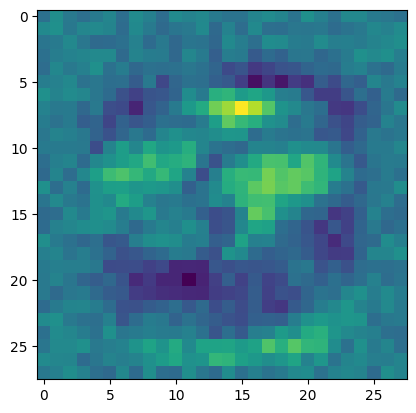

In [50]:
weight = list(model.children())[1].weight.cpu().data

print(list(model.children()))

for i, w in enumerate(weight):
    plt.imshow(torch.reshape(w, (28, 28)))
    plt.savefig(f"image_solutions/task_4b_{str(i)}.png")


### Task 4c)

Training epoch 4: 100%|██████████| 938/938 [00:07<00:00, 129.22it/s]


Average cross entropy loss : 		2.10
Accuracy: 	0.90


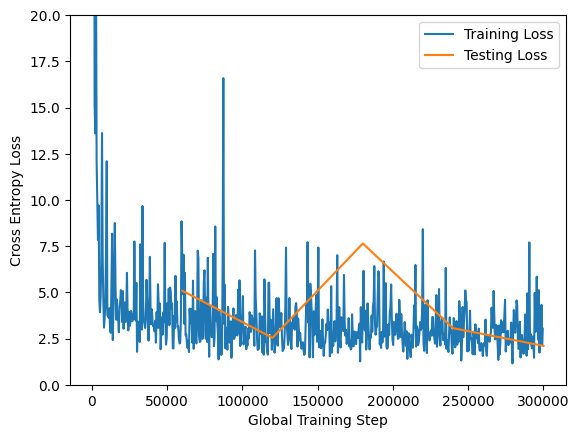

In [51]:
# Set the learning rate to lr = 1.0
learning_rate = 1.0

# Reload the dataset
dataloader_train, dataloader_test = dataloaders.load_dataset(
    batch_size, image_transform_normalized
)
example_images, _ = next(iter(dataloader_train))
example_images = utils.to_cuda(example_images)

# Creates a new model and optimizer with new learning rate
model = create_model()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Train again from scratch
trainer = Trainer(
    model=model,
    dataloader_train=dataloader_train,
    dataloader_test=dataloader_test,
    batch_size=batch_size,
    loss_function=loss_function,
    optimizer=optimizer,
)
task_c_train_loss_dict, task_c_test_loss_dict = trainer.train(num_epochs)

loss, accuracy = utils.compute_loss_and_accuracy(dataloader_test, model, loss_function)
print(f"Average cross entropy loss : \t\t{loss:.2f}\nAccuracy: \t{accuracy:.2f}")

# Plot results after training with learning rate of 1.0
utils.plot_loss(task_c_train_loss_dict, label="Training Loss")
utils.plot_loss(task_c_test_loss_dict, label="Testing Loss")
plt.ylim([0, 20])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig("image_solutions/task_4c.png")
plt.show()


### Task 4d)

Training epoch 4: 100%|██████████| 938/938 [00:07<00:00, 126.91it/s]


Average cross entropy loss : 		0.21
Accuracy: 	0.94
Difference in Loss: 		-0.0875
Difference in Accuracy: 	0.0243


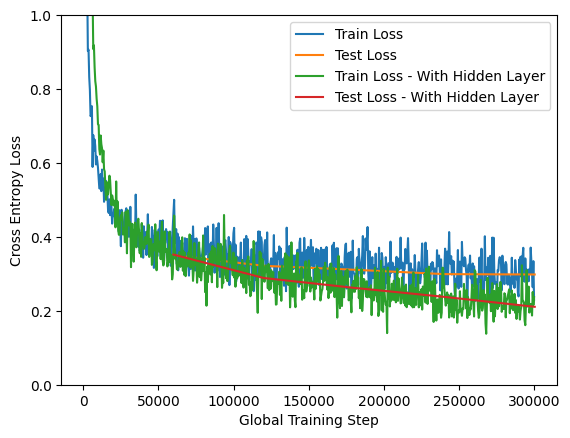

In [52]:
# Return the learning rate to initial value
learning_rate = 0.0192

def create_model_with_a_hidden_layer():
    model = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(28 * 28 * 1, 64),
        nn.ReLU(),
        nn.Linear(64, 10)
    )
    model = utils.to_cuda(model)
    return model

# Reload the dataset
dataloader_train, dataloader_test = dataloaders.load_dataset(
    batch_size, image_transform_normalized
)
example_images, _ = next(iter(dataloader_train))
example_images = utils.to_cuda(example_images)

# Creates a new model with a hidden layer
hidden_layer_model = create_model_with_a_hidden_layer()
optimizer = torch.optim.SGD(hidden_layer_model.parameters(), lr=learning_rate)

# Train again from with new model
trainer = Trainer(
    model=hidden_layer_model,
    dataloader_train=dataloader_train,
    dataloader_test=dataloader_test,
    batch_size=batch_size,
    loss_function=loss_function,
    optimizer=optimizer,
)
task_d_train_loss_dict, task_d_test_loss_dict = trainer.train(num_epochs)

loss, accuracy = utils.compute_loss_and_accuracy(dataloader_test, hidden_layer_model, loss_function)
print(f"Average cross entropy loss : \t\t{loss:.2f}\nAccuracy: \t{accuracy:.2f}")
print(f"Difference in Loss: \t\t{loss - normalized_loss:.4f}\nDifference in Accuracy: \t{accuracy - normalized_accuracy:.4f}")

# Plot results after training with learning rate of 1.0
utils.plot_loss(task_a_normalized_train_loss_dict, label="Train Loss")
utils.plot_loss(task_a_normalized_test_loss_dict, label="Test Loss")
utils.plot_loss(task_d_train_loss_dict, label="Train Loss - With Hidden Layer")
utils.plot_loss(task_d_test_loss_dict, label="Test Loss - With Hidden Layer")
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig("image_solutions/task_4d.png")
plt.show()
